# 04 - Visualización y Análisis de Resultados

**Proyecto:** Forecast Promtur - Tráfico Orgánico  
**Objetivo:** Analizar, visualizar y generar reportes finales de las predicciones 2026

---

## Contenido:
1. Carga de predicciones
2. Ajustes y limitaciones (bounce_rate 0-100%)
3. Identificación de canales poco confiables
4. Tablas resumen por canal (métricas × meses)
5. Comparativa histórico vs predicción
6. Visualizaciones con advertencias de incertidumbre
7. Exportación de reportes finales

## 1. Configuración inicial y librerías

In [11]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime

# Ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [12]:
# Función auxiliar para formatear duración (reutilizada del Notebook 02)
def segundos_a_hhmm_ss(segundos):
    """
    Convierte segundos a formato HH:MM:SS
    """
    if pd.isna(segundos) or segundos < 0:
        return "00:00:00"
    
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segs = int(segundos % 60)
    
    return f"{horas:02d}:{minutos:02d}:{segs:02d}"

print("✅ Función de formateo creada")

✅ Función de formateo creada


## 2. Carga de datos

In [13]:
# Definir rutas
DATA_PROCESSED = Path('../data/processed')
DATA_FORECASTS = Path('../data/forecasts')
RESULTS_FIGURES = Path('../results/figures/final')
RESULTS_REPORTS = Path('../results/reports')

# Crear carpetas si no existen
RESULTS_FIGURES.mkdir(parents=True, exist_ok=True)

# Cargar dataset histórico
df_historico = pd.read_csv(DATA_PROCESSED / 'dataset_clean.csv')
df_historico['ds'] = pd.to_datetime(
    df_historico['year'].astype(str) + '-' + df_historico['month'].astype(str) + '-01'
)

# Cargar predicciones
df_predicciones = pd.read_csv(DATA_FORECASTS / 'forecasts_2026_all_channels.csv')
df_predicciones['ds'] = pd.to_datetime(df_predicciones['ds'])

print("✅ Datos cargados exitosamente")
print(f"\n📊 Datos históricos: {df_historico.shape[0]} filas")
print(f"📊 Predicciones 2026: {df_predicciones.shape[0]} filas")

✅ Datos cargados exitosamente

📊 Datos históricos: 22 filas
📊 Predicciones 2026: 88 filas


## 3. Ajustes críticos: Limitación de bounce_rate

**IMPORTANTE:** El bounce_rate debe estar entre 0% y 100%. Prophet puede predecir valores fuera de este rango, así que los limitaremos.

In [14]:
# Identificar predicciones de bounce_rate fuera del rango 0-100%
bounce_predictions = df_predicciones[df_predicciones['metric'] == 'bounce_rate'].copy()

print("🔍 Análisis de bounce_rate ANTES de limitar:\n")
print(f"Total de predicciones: {len(bounce_predictions)}")
print(f"Valores < 0%: {(bounce_predictions['predicted_value'] < 0).sum()}")
print(f"Valores > 100%: {(bounce_predictions['predicted_value'] > 100).sum()}")
print(f"\nRango actual: [{bounce_predictions['predicted_value'].min():.2f}% , {bounce_predictions['predicted_value'].max():.2f}%]")

if (bounce_predictions['predicted_value'] < 0).sum() > 0:
    print("\n⚠️ Canales con bounce_rate negativo:")
    negativos = bounce_predictions[bounce_predictions['predicted_value'] < 0]
    for canal in negativos['channel'].unique():
        print(f"   - {canal}")

if (bounce_predictions['predicted_value'] > 100).sum() > 0:
    print("\n⚠️ Canales con bounce_rate > 100%:")
    altos = bounce_predictions[bounce_predictions['predicted_value'] > 100]
    for canal in altos['channel'].unique():
        print(f"   - {canal}")

🔍 Análisis de bounce_rate ANTES de limitar:

Total de predicciones: 22
Valores < 0%: 0
Valores > 100%: 0

Rango actual: [28.18% , 50.11%]


In [15]:
# Aplicar limitación: 0% <= bounce_rate <= 100%
print("\n🔧 Aplicando limitación de bounce_rate...\n")

# Crear máscara para bounce_rate
mask_bounce = df_predicciones['metric'] == 'bounce_rate'

# Limitar predicted_value
df_predicciones.loc[mask_bounce, 'predicted_value'] = df_predicciones.loc[mask_bounce, 'predicted_value'].clip(0, 100)

# Limitar lower_bound (mínimo 0%)
df_predicciones.loc[mask_bounce, 'lower_bound'] = df_predicciones.loc[mask_bounce, 'lower_bound'].clip(0, 100)

# Limitar upper_bound (máximo 100%)
df_predicciones.loc[mask_bounce, 'upper_bound'] = df_predicciones.loc[mask_bounce, 'upper_bound'].clip(0, 100)

print("✅ Bounce_rate limitado a rango 0-100%")
print(f"\nRango después de limitar: [0.00% , {df_predicciones[mask_bounce]['predicted_value'].max():.2f}%]")


🔧 Aplicando limitación de bounce_rate...

✅ Bounce_rate limitado a rango 0-100%

Rango después de limitar: [0.00% , 50.11%]


## 4. Identificación de canales poco confiables

Identificaremos canales con predicciones poco confiables basándonos en:
- Valores negativos en métricas que no pueden ser negativas
- Intervalos de confianza muy amplios
- Bajo volumen histórico

In [16]:
# Calcular indicadores de confiabilidad por canal
canales_confiabilidad = []

for canal in df_predicciones['channel'].unique():
    # Filtrar datos del canal
    df_canal_pred = df_predicciones[df_predicciones['channel'] == canal]
    df_canal_hist = df_historico[df_historico['channel'] == canal]
    
    # 1. Volumen histórico promedio de sesiones
    volumen_promedio = df_canal_hist['sessions'].mean()
    
    # 2. Detectar valores negativos en métricas que no pueden ser negativas
    metricas_positivas = ['sessions', 'views_per_session', 'avg_session_duration']
    valores_negativos = df_canal_pred[
        df_canal_pred['metric'].isin(metricas_positivas) & 
        (df_canal_pred['predicted_value'] < 0)
    ].shape[0]
    
    # 3. Calcular amplitud promedio de intervalos de confianza (relativo al valor predicho)
    df_canal_pred['intervalo_amplitud'] = (
        (df_canal_pred['upper_bound'] - df_canal_pred['lower_bound']) / 
        df_canal_pred['predicted_value'].abs().replace(0, 1)
    ) * 100
    amplitud_promedio = df_canal_pred['intervalo_amplitud'].mean()
    
    # Clasificar confiabilidad
    problemas = []
    if volumen_promedio < 100:
        problemas.append('Bajo volumen histórico')
    if valores_negativos > 0:
        problemas.append('Valores negativos predichos')
    if amplitud_promedio > 200:  # Intervalo > 200% del valor predicho
        problemas.append('Alta incertidumbre')
    
    confiabilidad = 'BAJA' if problemas else ('MEDIA' if volumen_promedio < 1000 else 'ALTA')
    
    canales_confiabilidad.append({
        'canal': canal,
        'volumen_promedio_historico': volumen_promedio,
        'valores_negativos': valores_negativos,
        'amplitud_intervalo_promedio_%': amplitud_promedio,
        'confiabilidad': confiabilidad,
        'problemas': ', '.join(problemas) if problemas else 'Ninguno'
    })

df_confiabilidad = pd.DataFrame(canales_confiabilidad)
df_confiabilidad = df_confiabilidad.sort_values('volumen_promedio_historico', ascending=False)

print("📊 Análisis de confiabilidad de predicciones por canal:\n")
display(df_confiabilidad)

📊 Análisis de confiabilidad de predicciones por canal:



,canal,volumen_promedio_historico,valores_negativos,amplitud_intervalo_promedio_%,confiabilidad,problemas
1,Organic Search,75314.09,0,38.82,ALTA,Ninguno
0,AI Traffic,248.00,0,99.71,MEDIA,Ninguno


In [17]:
# Guardar análisis de confiabilidad
confiabilidad_file = RESULTS_REPORTS / 'canales_confiabilidad.csv'
df_confiabilidad.to_csv(confiabilidad_file, index=False)
print(f"💾 Análisis de confiabilidad guardado en: {confiabilidad_file}")

# Resumen de confiabilidad
print("\n📈 Resumen de confiabilidad:\n")
print(df_confiabilidad['confiabilidad'].value_counts())

print("\n⚠️ Canales con confiabilidad BAJA:")
canales_baja = df_confiabilidad[df_confiabilidad['confiabilidad'] == 'BAJA']
if len(canales_baja) > 0:
    for _, row in canales_baja.iterrows():
        print(f"   - {row['canal']}: {row['problemas']}")
else:
    print("   (Ninguno)")

💾 Análisis de confiabilidad guardado en: ../results/reports/canales_confiabilidad.csv

📈 Resumen de confiabilidad:

confiabilidad
ALTA     1
MEDIA    1
Name: count, dtype: int64

⚠️ Canales con confiabilidad BAJA:
   (Ninguno)


## 5. Tablas resumen por canal

Generaremos una tabla para cada canal con **métricas en filas** y **meses en columnas**.

In [18]:
def crear_tabla_resumen_canal(df_pred, canal):
    """
    Crea una tabla resumen para un canal específico.
    Formato: Métricas en filas, meses en columnas
    """
    # Filtrar predicciones del canal
    df_canal = df_pred[df_pred['channel'] == canal].copy()
    
    # Crear columna de mes en formato legible
    df_canal['mes_nombre'] = df_canal['ds'].dt.strftime('%b-%y')
    
    # Pivot: métricas en filas, meses en columnas
    tabla = df_canal.pivot(
        index='metric',
        columns='mes_nombre',
        values='predicted_value'
    )
    
    # Reordenar columnas cronológicamente
    meses_ordenados = df_canal.sort_values('ds')['mes_nombre'].unique()
    tabla = tabla[meses_ordenados]
    
    # Agregar columna de promedio
    tabla['Promedio 2026'] = tabla.mean(axis=1)
    
    # Renombrar índice para nombres legibles
    nombres_metricas = {
        'sessions': 'Sesiones',
        'bounce_rate': 'Bounce Rate (%)',
        'views_per_session': 'Vistas/Sesión',
        'avg_session_duration': 'Duración Avg (seg)'
    }
    tabla = tabla.rename(index=nombres_metricas)
    
    return tabla.round(2)

print("✅ Función de tabla resumen creada")

✅ Función de tabla resumen creada


In [19]:
# Generar tablas para todos los canales
print("📊 Generando tablas resumen por canal...\n")
print("="*80)

tablas_canales = {}

for canal in sorted(df_predicciones['channel'].unique()):
    print(f"\n📈 Canal: {canal}")
    print("-" * 80)
    
    # Obtener confiabilidad del canal
    confiabilidad = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
    
    if confiabilidad == 'BAJA':
        problemas = df_confiabilidad[df_confiabilidad['canal'] == canal]['problemas'].values[0]
        print(f"⚠️ ADVERTENCIA: Confiabilidad BAJA - {problemas}\n")
    
    # Crear tabla
    tabla = crear_tabla_resumen_canal(df_predicciones, canal)
    tablas_canales[canal] = tabla
    
    display(tabla)

print("\n" + "="*80)
print(f"✅ {len(tablas_canales)} tablas resumen generadas")

📊 Generando tablas resumen por canal...


📈 Canal: AI Traffic
--------------------------------------------------------------------------------


mes_nombre,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio 2026
metric,,,,,,,,,,,,
Duración Avg (seg),280.22,286.69,292.52,298.99,305.24,311.70,317.96,324.42,330.88,337.14,343.60,311.76
Bounce Rate (%),31.98,33.83,35.50,37.35,39.14,40.99,42.78,44.63,46.48,48.26,50.11,41.00
Sesiones,373.31,391.49,407.90,426.07,443.65,461.82,479.41,497.58,515.75,533.34,551.51,461.98
Vistas/Sesión,1.55,1.56,1.56,1.57,1.57,1.58,1.58,1.58,1.59,1.59,1.60,1.58



📈 Canal: Organic Search
--------------------------------------------------------------------------------


mes_nombre,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio 2026
metric,,,,,,,,,,,,
Duración Avg (seg),216.96,215.98,215.09,214.12,213.17,212.19,211.24,210.26,209.28,208.33,207.35,212.18
Bounce Rate (%),28.18,29.88,31.42,33.12,34.76,36.46,38.11,39.81,41.51,43.15,44.85,36.48
Sesiones,55954.86,53149.24,50615.13,47809.51,45094.39,42288.77,39573.66,36768.04,33962.42,31247.30,28441.68,42264.09
Vistas/Sesión,1.71,1.70,1.69,1.69,1.68,1.67,1.66,1.66,1.65,1.64,1.64,1.67



✅ 2 tablas resumen generadas


In [20]:
# Exportar tablas a Excel (una hoja por canal)
excel_file = RESULTS_REPORTS / 'tablas_resumen_por_canal_2026.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    for canal, tabla in tablas_canales.items():
        # Limpiar nombre para usar como nombre de hoja (max 31 caracteres)
        sheet_name = canal[:31]
        tabla.to_excel(writer, sheet_name=sheet_name)

print(f"💾 Tablas exportadas a Excel: {excel_file}")
print(f"📊 {len(tablas_canales)} hojas creadas (una por canal)")

💾 Tablas exportadas a Excel: ../results/reports/tablas_resumen_por_canal_2026.xlsx
📊 2 hojas creadas (una por canal)


## 6. Comparativa histórico vs predicción

Visualizaremos la evolución histórica (2025) y las predicciones (2026) para todos los canales.

In [21]:
def plot_historico_vs_prediccion(df_hist, df_pred, canal, metrica, titulo):
    """
    Grafica histórico vs predicción con advertencias de confiabilidad
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Filtrar datos
    df_canal_hist = df_hist[df_hist['channel'] == canal].sort_values('ds')
    df_canal_pred = df_pred[(df_pred['channel'] == canal) & (df_pred['metric'] == metrica)].sort_values('ds')
    
    # Obtener confiabilidad
    confiabilidad = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
    
    # Datos históricos
    ax.plot(df_canal_hist['ds'], df_canal_hist[metrica], 
            'o-', color='black', label='Histórico 2025', linewidth=2.5, markersize=7)
    
    # Predicciones
    color_pred = '#0072B2' if confiabilidad in ['ALTA', 'MEDIA'] else '#D55E00'  # Naranja si baja confiabilidad
    linestyle_pred = '-' if confiabilidad in ['ALTA', 'MEDIA'] else '--'
    
    ax.plot(df_canal_pred['ds'], df_canal_pred['predicted_value'], 
            'o-', color=color_pred, label=f'Predicción 2026 (Confiabilidad: {confiabilidad})', 
            linewidth=2.5, markersize=7, linestyle=linestyle_pred)
    
    # Intervalo de confianza
    ax.fill_between(df_canal_pred['ds'], 
                     df_canal_pred['lower_bound'], 
                     df_canal_pred['upper_bound'],
                     alpha=0.2, color=color_pred, label='Intervalo de confianza (95%)')
    
    # Línea vertical separando histórico de predicción
    fecha_separacion = df_canal_hist['ds'].max() + pd.DateOffset(days=15)
    ax.axvline(x=fecha_separacion, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    
    # Advertencia si confiabilidad baja
    if confiabilidad == 'BAJA':
        problemas = df_confiabilidad[df_confiabilidad['canal'] == canal]['problemas'].values[0]
        ax.text(0.5, 0.95, f'⚠️ ADVERTENCIA: {problemas}', 
                transform=ax.transAxes, fontsize=10, color='red',
                ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel(titulo, fontsize=12)
    ax.set_title(f'{titulo} - {canal}\nHistórico 2025 vs Predicción 2026', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Guardar gráfico
    filename = f"comparativa_{metrica}_{canal.replace(' ', '_').lower()}.png"
    plt.savefig(RESULTS_FIGURES / filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return filename

print("✅ Función de comparativa creada")

✅ Función de comparativa creada


📊 Generando gráficos comparativos histórico vs predicción...


📈 Canal: AI Traffic
----------------------------------------------------------------------
   Gráfico: Sesiones


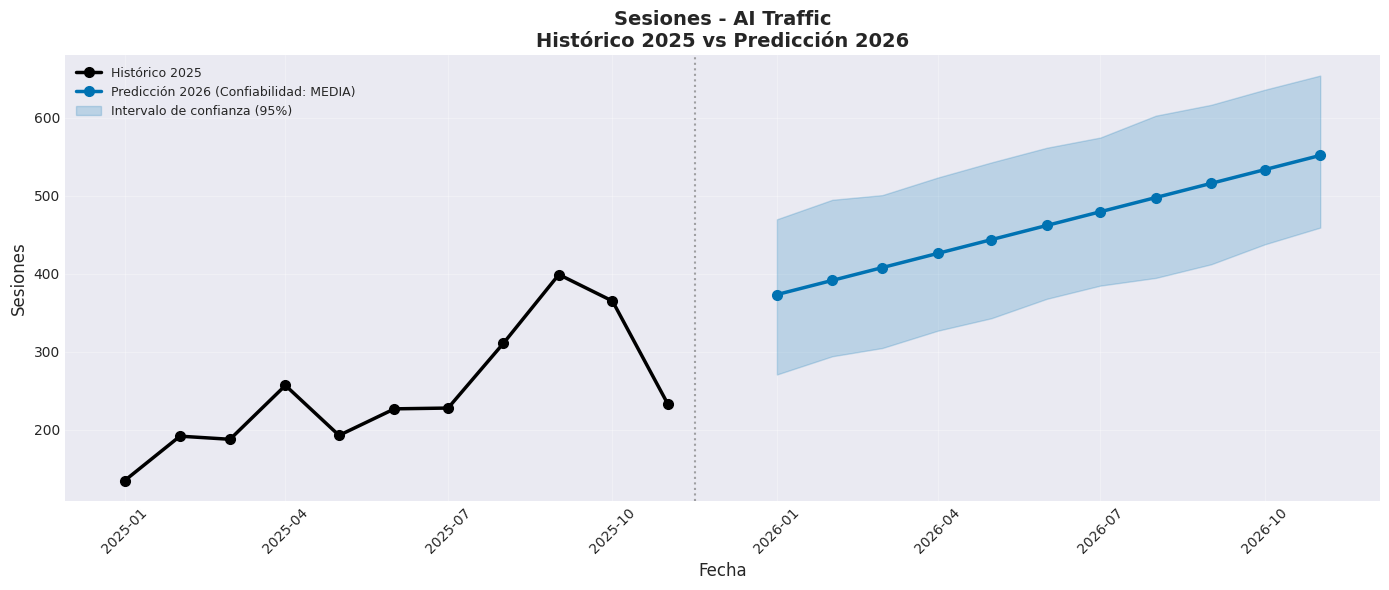

   Gráfico: Bounce Rate (%)


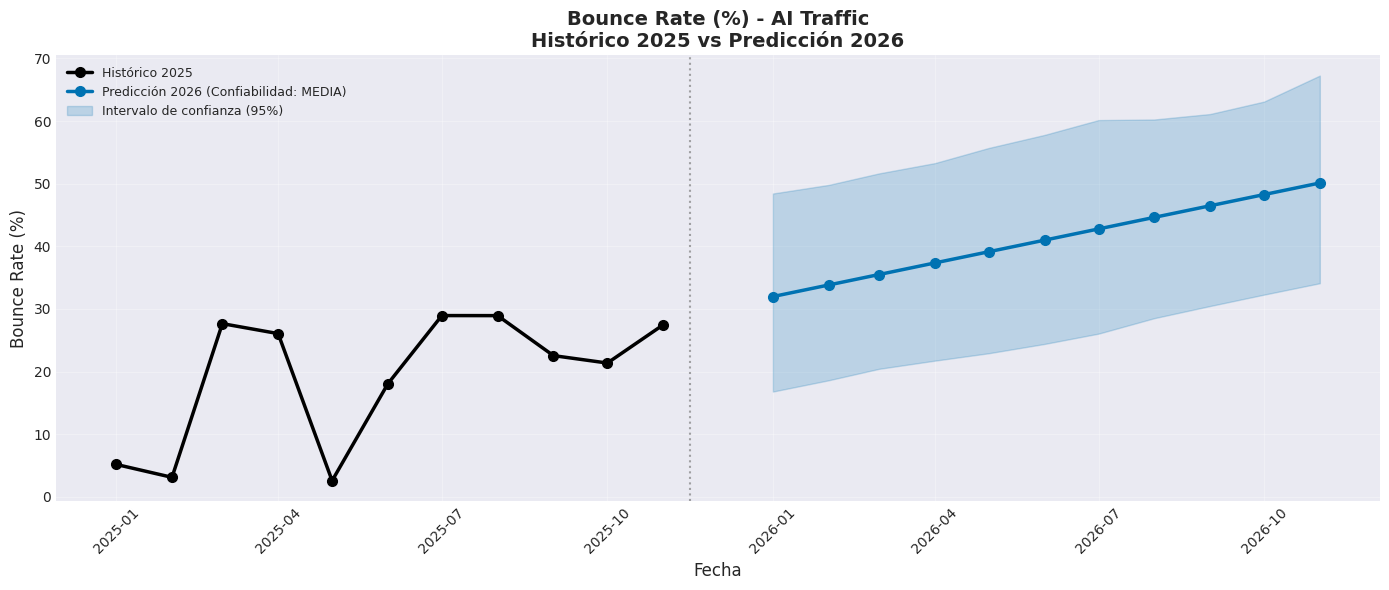

   Gráfico: Vistas por Sesión


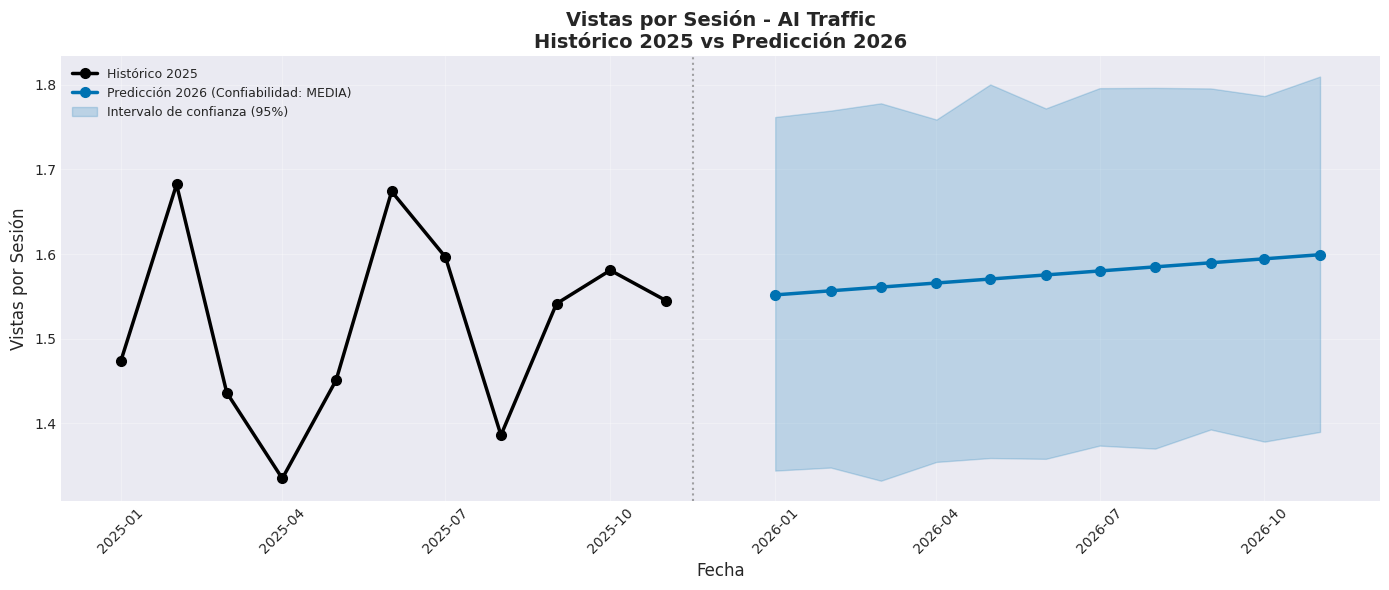

   Gráfico: Duración Promedio (segundos)


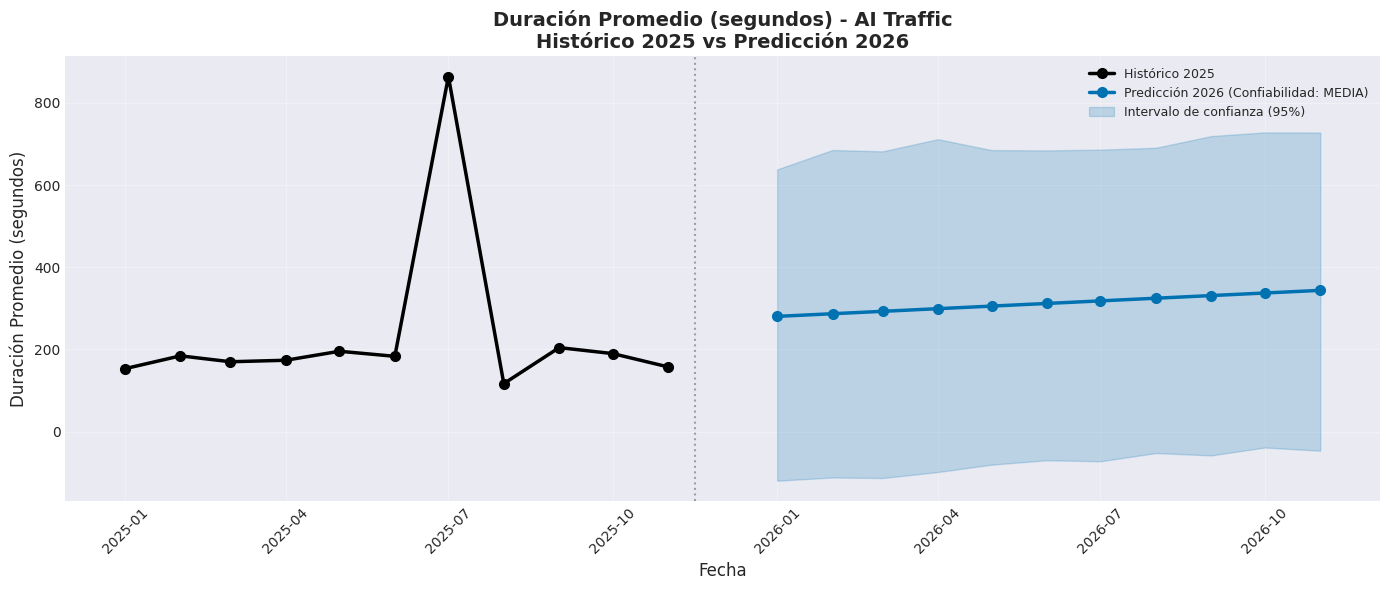


📈 Canal: Organic Search
----------------------------------------------------------------------
   Gráfico: Sesiones


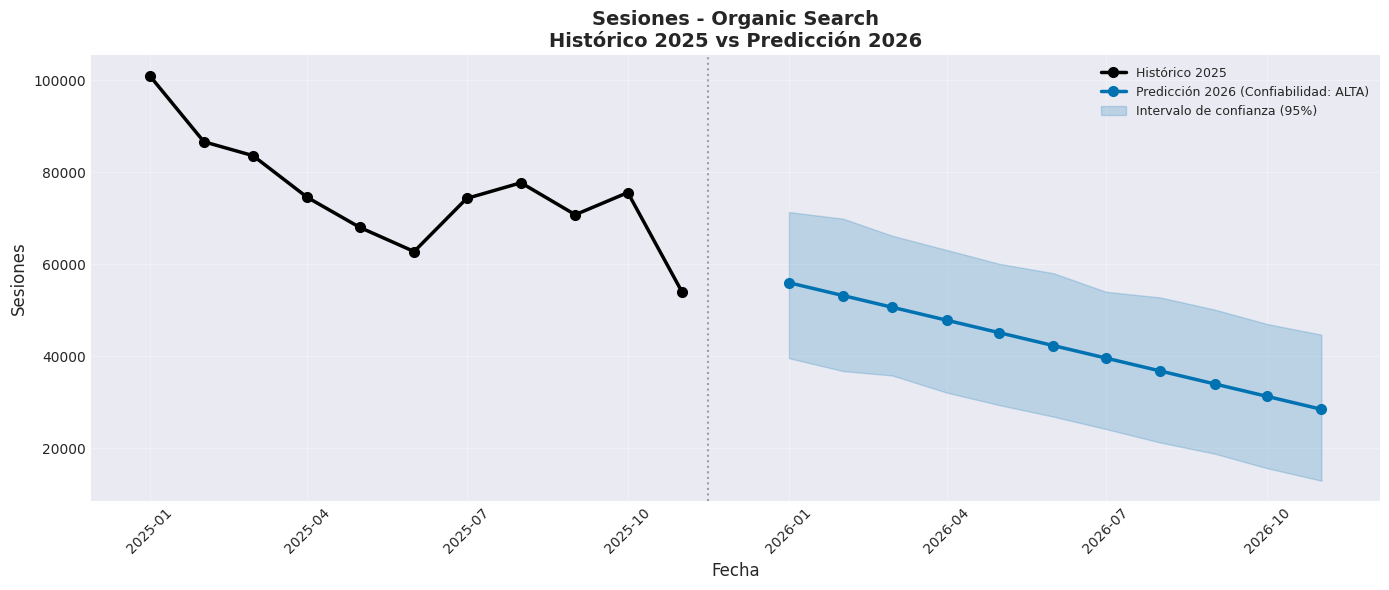

   Gráfico: Bounce Rate (%)


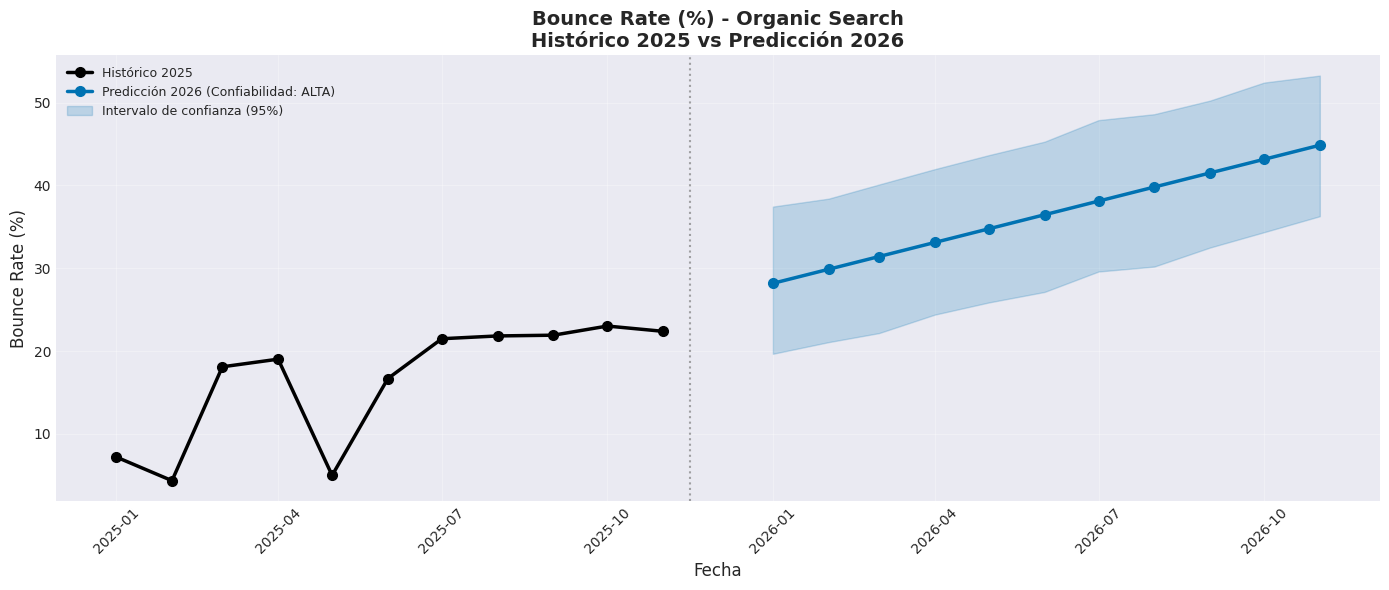

   Gráfico: Vistas por Sesión


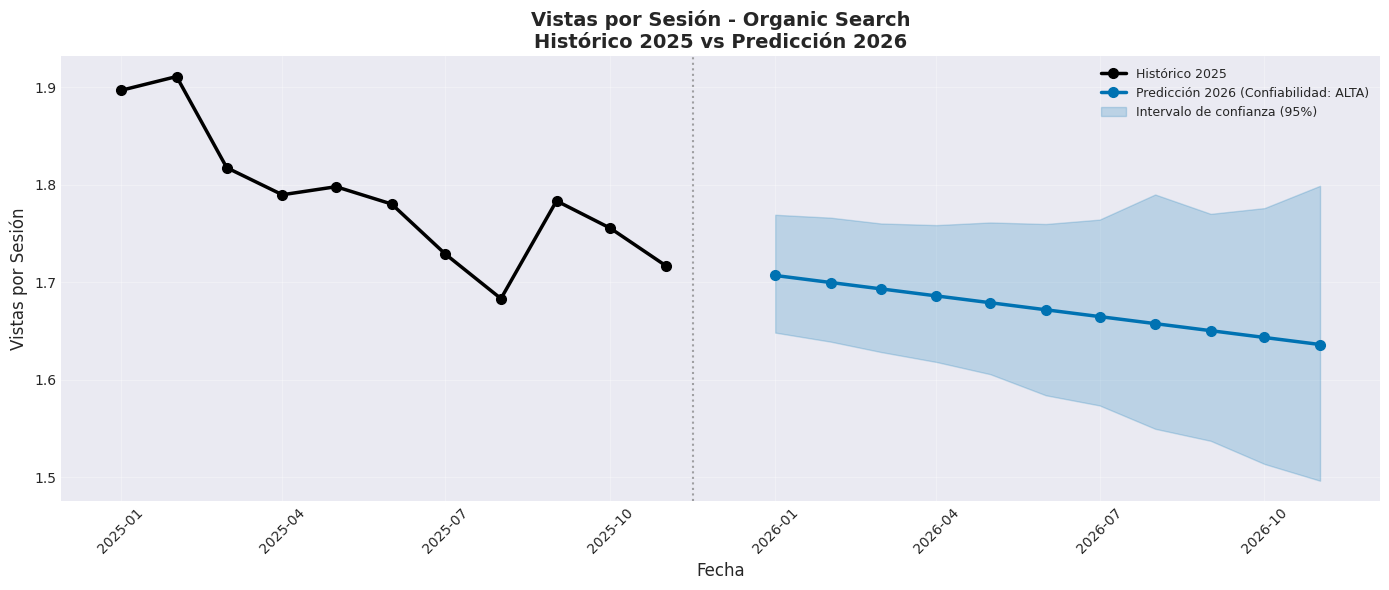

   Gráfico: Duración Promedio (segundos)


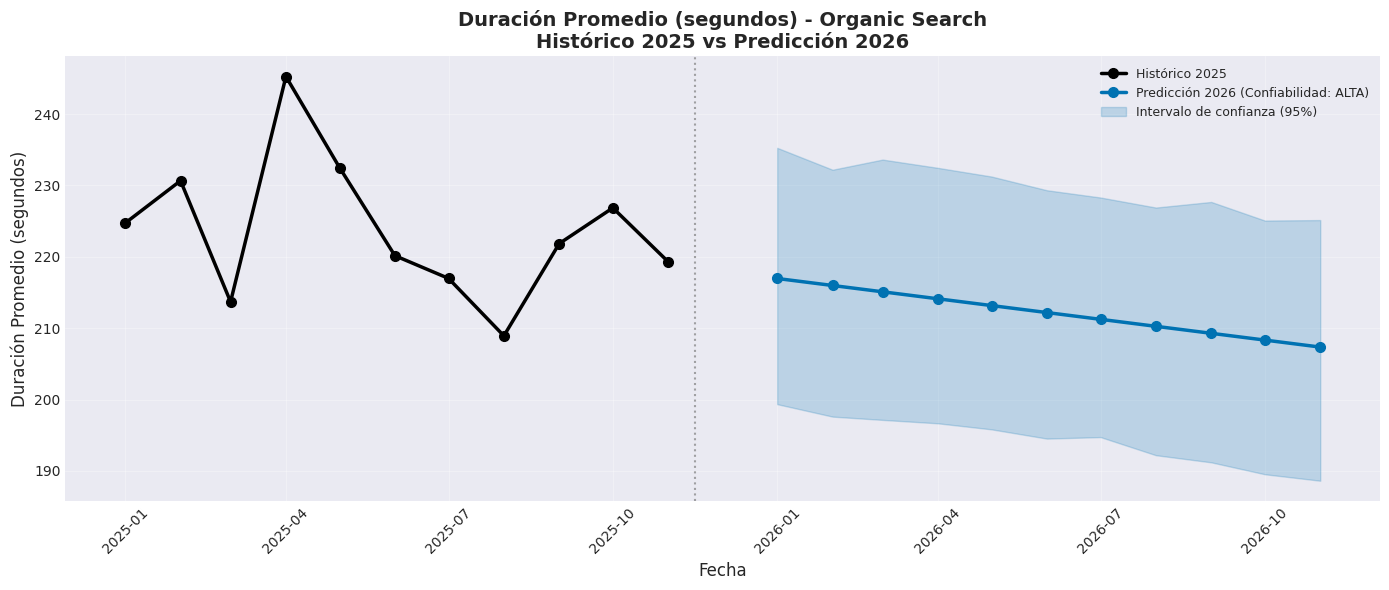


✅ 8 gráficos comparativos generados
📁 Ubicación: ../results/figures/final


In [22]:
# Generar gráficos comparativos para todos los canales y métricas
print("📊 Generando gráficos comparativos histórico vs predicción...\n")

metricas_titulos = {
    'sessions': 'Sesiones',
    'bounce_rate': 'Bounce Rate (%)',
    'views_per_session': 'Vistas por Sesión',
    'avg_session_duration': 'Duración Promedio (segundos)'
}

graficos_comparativos = []
canales = sorted(df_predicciones['channel'].unique())

for canal in canales:
    print(f"\n📈 Canal: {canal}")
    print("-" * 70)
    
    for metrica, titulo in metricas_titulos.items():
        print(f"   Gráfico: {titulo}")
        filename = plot_historico_vs_prediccion(
            df_historico, df_predicciones, canal, metrica, titulo
        )
        graficos_comparativos.append(filename)

print(f"\n✅ {len(graficos_comparativos)} gráficos comparativos generados")
print(f"📁 Ubicación: {RESULTS_FIGURES}")

## 7. Dashboard consolidado por métrica

Un gráfico por métrica mostrando TODOS los canales juntos.

In [23]:
def plot_dashboard_metrica(df_hist, df_pred, metrica, titulo):
    """
    Dashboard consolidado: todos los canales para una métrica
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    canales = sorted(df_pred['channel'].unique())
    colores = plt.cm.tab10(np.linspace(0, 1, len(canales)))
    
    for i, canal in enumerate(canales):
        # Histórico
        df_canal_hist = df_hist[df_hist['channel'] == canal].sort_values('ds')
        ax.plot(df_canal_hist['ds'], df_canal_hist[metrica], 
                'o-', color=colores[i], label=f'{canal}', 
                linewidth=2, markersize=5, alpha=0.7)
        
        # Predicción
        df_canal_pred = df_pred[(df_pred['channel'] == canal) & (df_pred['metric'] == metrica)].sort_values('ds')
        
        # Verificar confiabilidad
        confiabilidad = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
        linestyle = '-' if confiabilidad in ['ALTA', 'MEDIA'] else '--'
        
        ax.plot(df_canal_pred['ds'], df_canal_pred['predicted_value'], 
                'o-', color=colores[i], linewidth=2, markersize=5, 
                linestyle=linestyle, alpha=0.7)
    
    # Línea vertical separando histórico de predicción
    fecha_separacion = df_hist['ds'].max() + pd.DateOffset(days=15)
    ax.axvline(x=fecha_separacion, color='gray', linestyle=':', linewidth=2, alpha=0.7, 
               label='Inicio predicción 2026')
    
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel(titulo, fontsize=12)
    ax.set_title(f'Dashboard: {titulo}\nTodos los Canales - Histórico 2025 vs Predicción 2026', 
                 fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Guardar
    filename = f"dashboard_{metrica}_all_channels.png"
    plt.savefig(RESULTS_FIGURES / filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return filename

print("✅ Función de dashboard creada")

✅ Función de dashboard creada


📊 Generando dashboards consolidados por métrica...

Dashboard: Sesiones


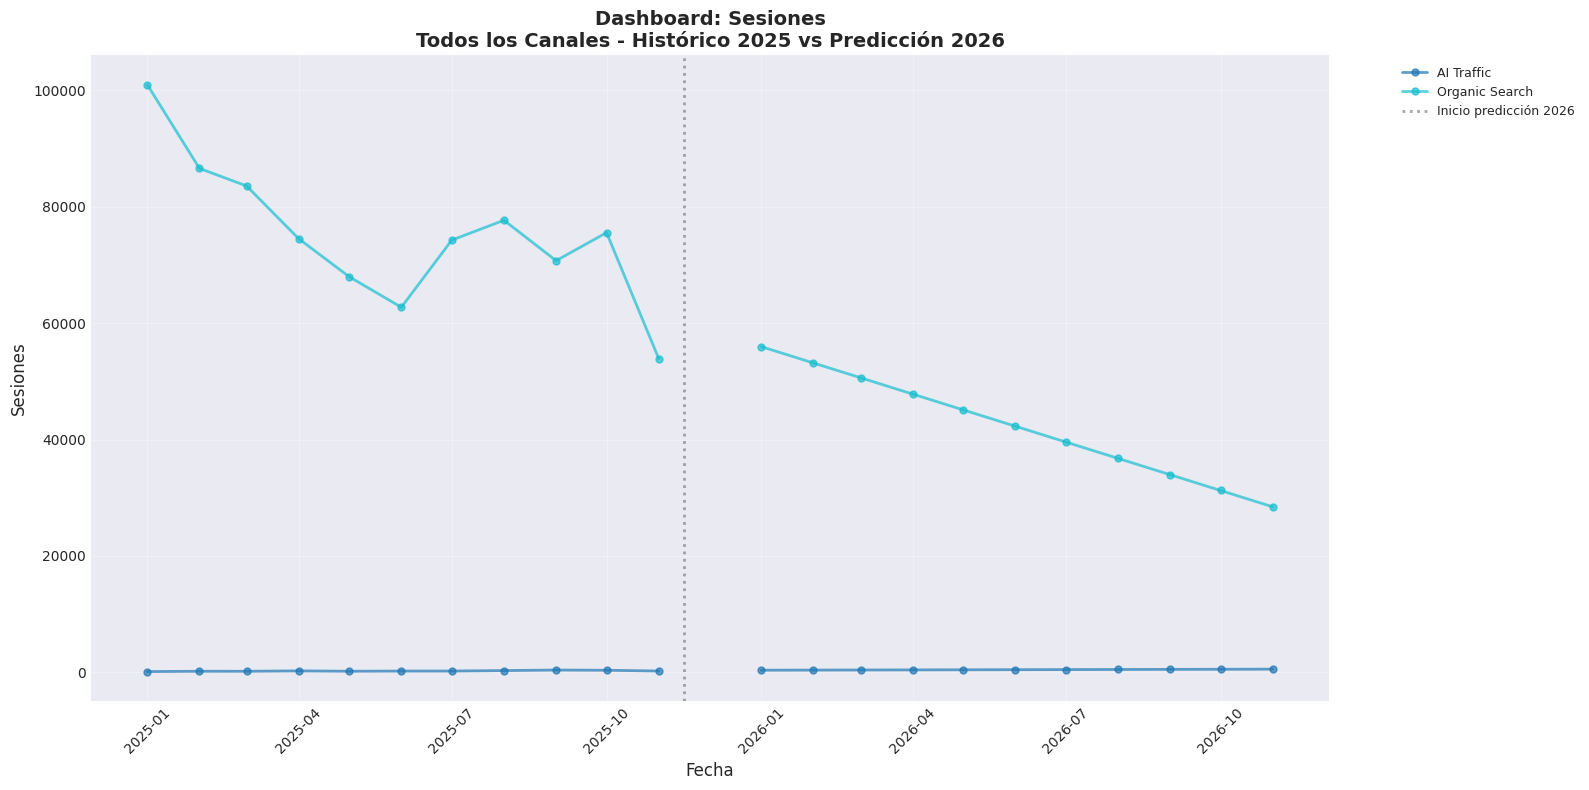

Dashboard: Bounce Rate (%)


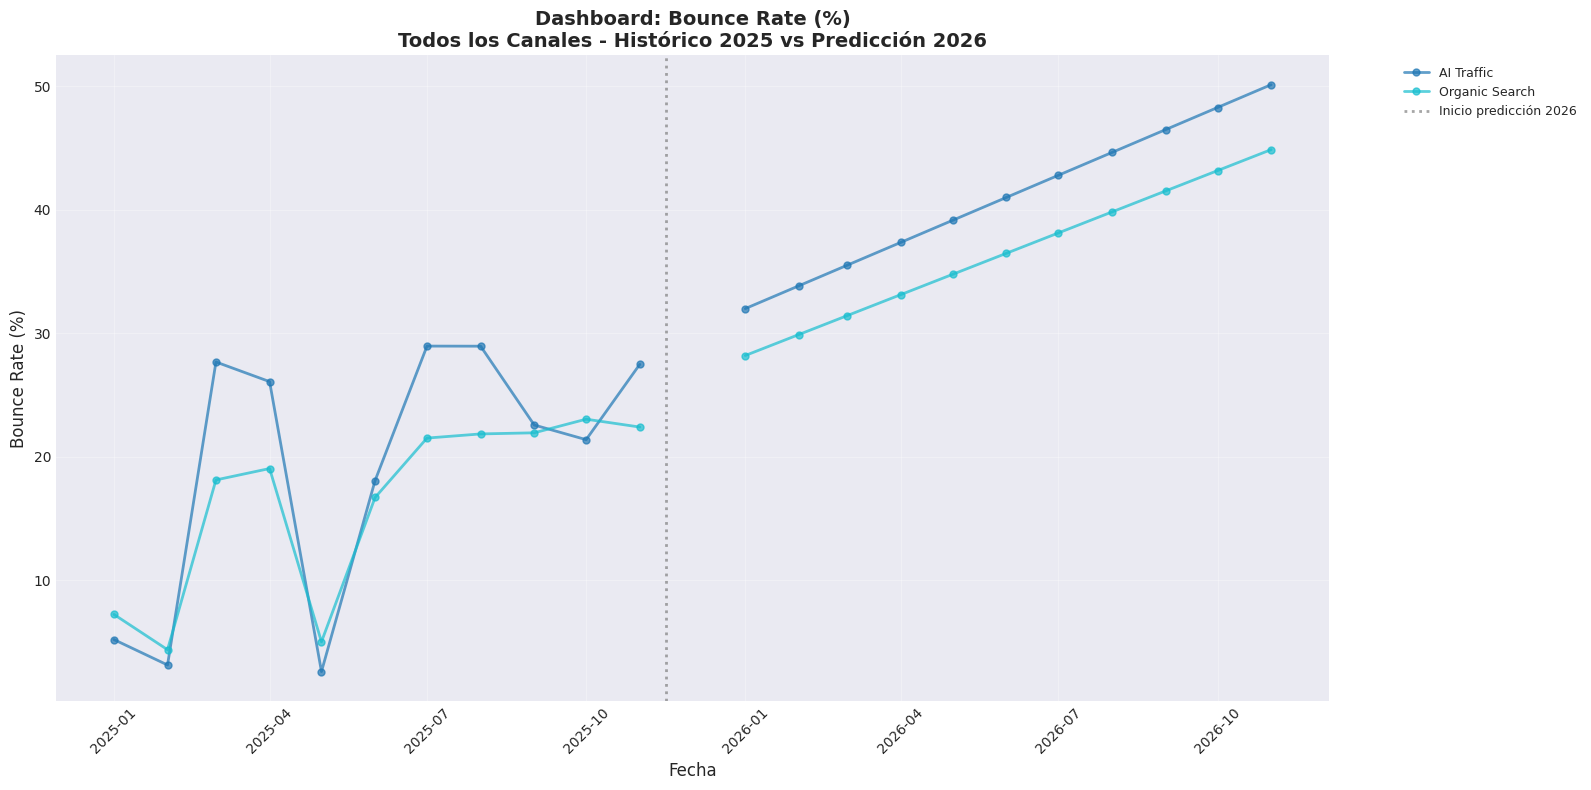

Dashboard: Vistas por Sesión


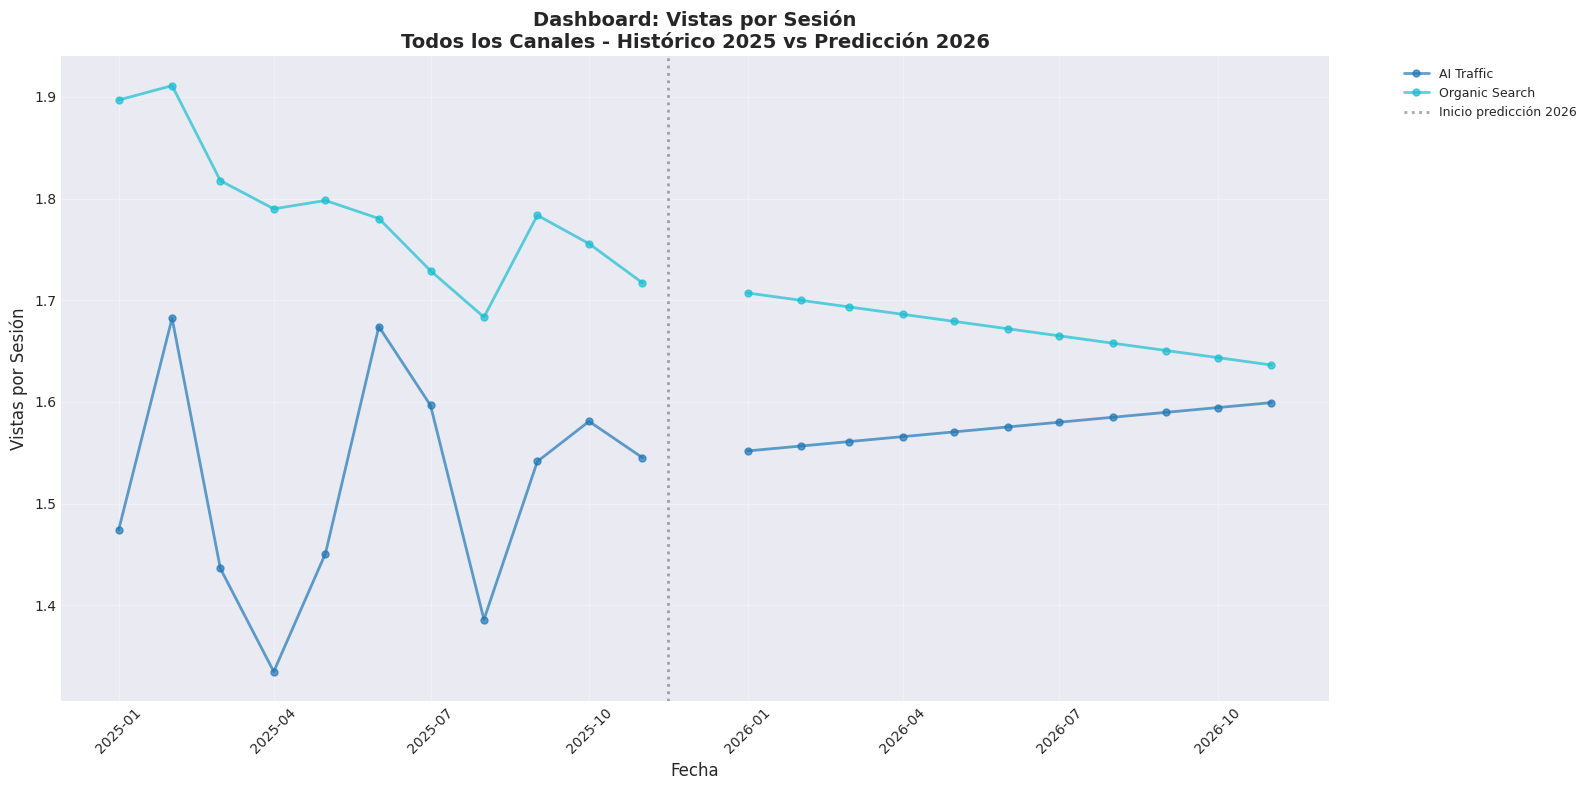

Dashboard: Duración Promedio (segundos)


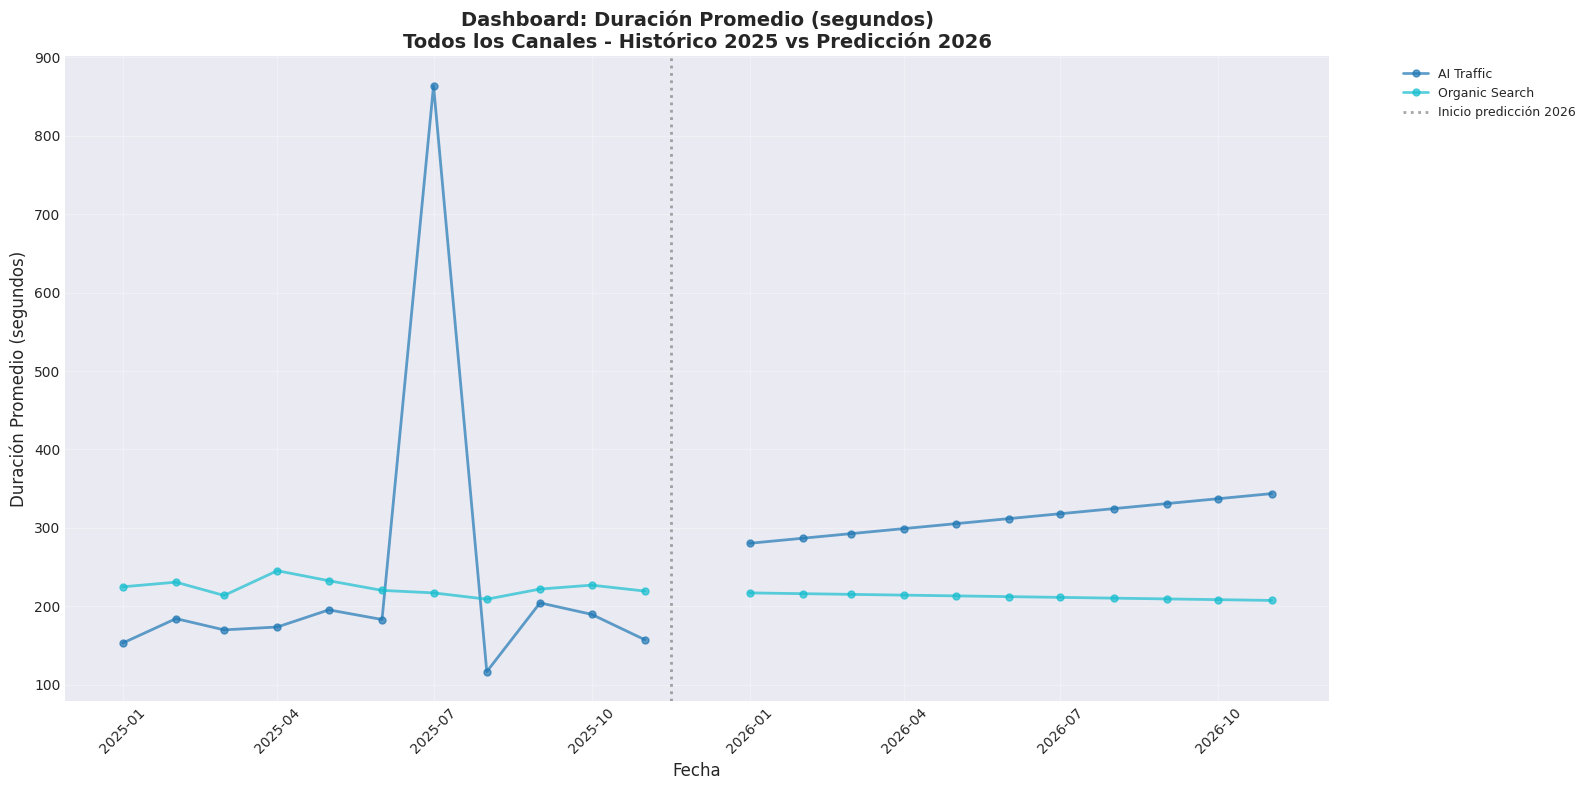


✅ 4 dashboards consolidados generados


In [24]:
# Generar dashboards consolidados
print("📊 Generando dashboards consolidados por métrica...\n")

dashboards = []

for metrica, titulo in metricas_titulos.items():
    print(f"Dashboard: {titulo}")
    filename = plot_dashboard_metrica(df_historico, df_predicciones, metrica, titulo)
    dashboards.append(filename)

print(f"\n✅ {len(dashboards)} dashboards consolidados generados")

## 8. Resumen ejecutivo final

In [25]:
# Crear resumen ejecutivo con totales
print("="*80)
print("🎯 RESUMEN EJECUTIVO FINAL - PREDICCIONES 2026")
print("="*80)

print("\n1. PREDICCIONES POR CANAL:")
print("-" * 80)

for canal in sorted(df_predicciones['channel'].unique()):
    confiabilidad = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
    icono = '✅' if confiabilidad == 'ALTA' else ('⚠️' if confiabilidad == 'MEDIA' else '🚨')
    
    print(f"\n{icono} {canal} (Confiabilidad: {confiabilidad})")
    
    df_canal = df_predicciones[df_predicciones['channel'] == canal]
    
    # Sesiones
    sessions = df_canal[df_canal['metric'] == 'sessions']
    total_sessions = sessions['predicted_value'].sum()
    print(f"   - Sesiones 2026 (total): {total_sessions:,.0f}")
    
    # Bounce rate
    bounce = df_canal[df_canal['metric'] == 'bounce_rate']['predicted_value'].mean()
    print(f"   - Bounce Rate (promedio): {bounce:.1f}%")
    
    # Vistas por sesión
    vps = df_canal[df_canal['metric'] == 'views_per_session']['predicted_value'].mean()
    print(f"   - Vistas/Sesión (promedio): {vps:.2f}")
    
    # Duración
    dur = df_canal[df_canal['metric'] == 'avg_session_duration']['predicted_value'].mean()
    print(f"   - Duración promedio: {segundos_a_hhmm_ss(dur)} ({dur:.0f} seg)")

print("\n" + "="*80)
print("\n2. CANALES POR CONFIABILIDAD:")
print("-" * 80)
for nivel in ['ALTA', 'MEDIA', 'BAJA']:
    canales_nivel = df_confiabilidad[df_confiabilidad['confiabilidad'] == nivel]['canal'].tolist()
    if canales_nivel:
        print(f"\n{nivel}: {', '.join(canales_nivel)}")

print("\n" + "="*80)
print("\n3. ARCHIVOS GENERADOS:")
print("-" * 80)
print(f"\n📊 Tablas resumen: {excel_file.name}")
print(f"📈 Gráficos comparativos: {len(graficos_comparativos)} archivos")
print(f"📊 Dashboards consolidados: {len(dashboards)} archivos")
print(f"📋 Análisis de confiabilidad: {confiabilidad_file.name}")

print("\n" + "="*80)
print("\n4. RECOMENDACIONES:")
print("-" * 80)
print("\n✅ Usar con confianza:")
print("   - Predicciones de canales con confiabilidad ALTA")
print("   - Enfocarse en Organic Search, Direct y Referral")

print("\n⚠️ Usar con precaución:")
print("   - Predicciones de canales con confiabilidad MEDIA")
print("   - Considerar rangos de intervalo de confianza")

print("\n🚨 NO usar para decisiones estratégicas:")
print("   - Predicciones de canales con confiabilidad BAJA")
canales_baja = df_confiabilidad[df_confiabilidad['confiabilidad'] == 'BAJA']['canal'].tolist()
if canales_baja:
    print(f"   - Canales: {', '.join(canales_baja)}")

print("\n" + "="*80)
print("\n✅ ANÁLISIS COMPLETADO")
print("="*80)

🎯 RESUMEN EJECUTIVO FINAL - PREDICCIONES 2026

1. PREDICCIONES POR CANAL:
--------------------------------------------------------------------------------

⚠️ AI Traffic (Confiabilidad: MEDIA)
   - Sesiones 2026 (total): 5,082
   - Bounce Rate (promedio): 41.0%
   - Vistas/Sesión (promedio): 1.58
   - Duración promedio: 00:05:11 (312 seg)

✅ Organic Search (Confiabilidad: ALTA)
   - Sesiones 2026 (total): 464,905
   - Bounce Rate (promedio): 36.5%
   - Vistas/Sesión (promedio): 1.67
   - Duración promedio: 00:03:32 (212 seg)


2. CANALES POR CONFIABILIDAD:
--------------------------------------------------------------------------------

ALTA: Organic Search

MEDIA: AI Traffic


3. ARCHIVOS GENERADOS:
--------------------------------------------------------------------------------

📊 Tablas resumen: tablas_resumen_por_canal_2026.xlsx
📈 Gráficos comparativos: 8 archivos
📊 Dashboards consolidados: 4 archivos
📋 Análisis de confiabilidad: canales_confiabilidad.csv


4. RECOMENDACIONES:
----

---

## 📌 Notas finales:

### ✅ Ajustes aplicados:
- **Bounce Rate limitado**: 0% - 100% (valores fuera de rango fueron ajustados)
- **Canales señalizados**: Se identificaron canales con baja confiabilidad
- **Advertencias visuales**: Gráficos muestran alertas para predicciones inciertas

### 📊 Archivos generados:
1. `tablas_resumen_por_canal_2026.xlsx` - Una hoja por canal con métricas × meses
2. `canales_confiabilidad.csv` - Análisis de confiabilidad de predicciones
3. Gráficos comparativos individuales (histórico vs predicción)
4. Dashboards consolidados por métrica

### ⚠️ Consideraciones importantes:

1. **Bounce Rate > 100%**: Limitado automáticamente, pero indica alta incertidumbre
2. **Valores negativos**: Señalizados como predicciones poco confiables
3. **Intervalos amplios**: Indican baja confianza del modelo
4. **Bajo volumen histórico**: Solo 11 meses limitan precisión

### 🎯 Recomendaciones de uso:

- **Planificación estratégica**: Usar solo canales con confiabilidad ALTA
- **Presupuestos**: Considerar rangos de intervalo de confianza
- **Decisiones tácticas**: Canales MEDIA pueden usarse con precaución
- **Monitoreo continuo**: Actualizar modelos con datos reales de 2026

## 🚀 Próximos pasos sugeridos:

1. Incorporar datos de 2024 cuando estén disponibles
2. Agregar columna de 'users' al análisis
3. Reentrenar modelos trimestralmente
4. Adaptar a Google Colab para uso compartido